# Chapter 2

## Fine-tuning Transformers, p. 45

### Starting off with a pretrained DistilBERT model

See [`distilbert-base-uncased`](https://huggingface.co/distilbert-base-uncased) at 🤗 Models.

We choose our checkpoint here, and start off by setting up a tokenizer.

In [1]:
checkpoint = "distilbert-base-uncased"

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [3]:
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


----

## Load up the dataset

In [4]:
from datasets import load_dataset

emotions = load_dataset("SetFit/emotion")
emotions

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [5]:
def tokenize_text(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [6]:
emotions_encoded = emotions.map(tokenize_text, batched=True, batch_size=None)
emotions_encoded

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

----

### Loading a pretrained model

In [7]:
id2label = dict(
    zip(
        emotions["train"].unique('label'), 
        emotions["train"].unique('label_text')
    )
)

id2label = dict(sorted(id2label.items(), key=lambda item: item[0]))
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [8]:
num_labels = len(id2label)

In [9]:
labels = id2label.values()

In [10]:
label2id = {v:k for k,v in id2label.items()}

In [11]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification
         .from_pretrained(
             checkpoint, 
             num_labels=num_labels,
             id2label=id2label,
             label2id=label2id
         ).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----

### Defining the performance metrics

Important APIs:

* [`sklearn.metrics.accuracy_score`]()
* [`sklearn.metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

`f1_score`'s `average=weighted` parameter...?
> Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

Compare this approach with that used in the 00_simple_training.ipynb notebook, section **Dealing with imbalanced classes**

In [12]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return { "accuracy": acc, "f1": f1 }

----

### Training the model

In [13]:
from transformers import TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size

model_name = f"{checkpoint}-finetuned-emotion"

"""
training_args = TrainingArguments(
    optim="adamw_torch",
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)
"""
training_args = TrainingArguments(
    optim="adamw_torch",
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_steps=logging_steps,
    fp16=True,
    push_to_hub=False,
    report_to="all"
)

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.761400,0.262633,0.916500,0.916550
2,0.200800,0.172337,0.930500,0.931112
3,0.137300,0.160838,0.936000,0.936489
4,0.105200,0.153873,0.940000,0.940083
5,0.086700,0.147183,0.935000,0.934953


TrainOutput(global_step=1250, training_loss=0.2582901138305664, metrics={'train_runtime': 86.257, 'train_samples_per_second': 927.461, 'train_steps_per_second': 14.492, 'total_flos': 1800857154240000.0, 'train_loss': 0.2582901138305664, 'epoch': 5.0})

In [15]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.14718326926231384,
 'test_accuracy': 0.935,
 'test_f1': 0.9349531780765996,
 'test_runtime': 0.5929,
 'test_samples_per_second': 3373.236,
 'test_steps_per_second': 53.972}

In [16]:
import numpy as np

y_preds = np.argmax(preds_output.predictions, axis=1)

y_valid = np.array(emotions_encoded["validation"]["label"])

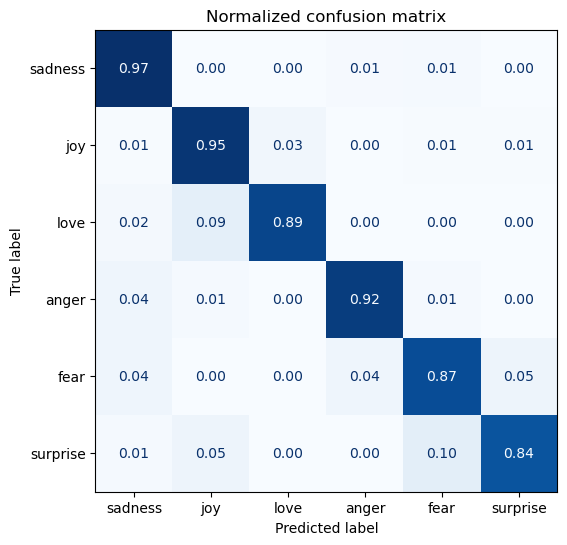

In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )
    disp.plot(
        cmap="Blues",
        values_format=".2f",
        ax=ax,
        colorbar=False
    )
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

----

### Error analysis

In [18]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # place all input tensors on the same device as the model!
    inputs = {
        k:v.to(device)
        for k,v in batch.items()
        if k in tokenizer.model_input_names
    }
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(
            output.logits,
            batch["label"].to(device),
            reduction="none"
        )
       
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }
            

In [19]:
emotions_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
)

emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label,
    batched=True,
    batch_size=16
)

Parameter 'function'=<function forward_pass_with_label at 0x7fe469a66e50> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [20]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(lambda v: id2label[v])
df_test["predicted_label"] = df_test["predicted_label"].apply(lambda v: id2label[v])

In [21]:
df_test.head()

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.003059
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.002916
2,i feel like a faithful servant,love,love,0.371369
3,i am just feeling cranky and blue,anger,anger,0.006265
4,i can have for a treat or if i am feeling festive,joy,joy,0.002249


In [22]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.530195
318,i felt ashamed of these feelings and was scare...,fear,sadness,6.443900
1509,i guess this is a memoir so it feels like that...,joy,fear,6.255221
1111,im lazy my characters fall into categories of ...,joy,fear,5.822304
1801,i feel that he was being overshadowed by the s...,love,sadness,5.684320
882,i feel badly about reneging on my commitment t...,love,sadness,5.458921
1963,i called myself pro life and voted for perry w...,joy,sadness,5.410792
1836,i got a very nasty electrical shock when i was...,fear,anger,4.629713
1683,i had applied for a job and they had assured m...,anger,joy,4.610557
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.464377


In [23]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.001972
452,i manage to complete the lap not too far behin...,joy,joy,0.002000
1607,i feel incredibly mellow and spacey,joy,joy,0.002085
702,i only find out that they are looking and feel...,joy,joy,0.002094
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.002114
1263,i feel this way about blake lively,joy,joy,0.002134
620,i shall move right along to the post interview...,joy,joy,0.002134
723,i was able to go to a st party i am back feeli...,joy,joy,0.002152
1565,im feeling a little mellow right now i have to...,joy,joy,0.002153
908,i said earlier that the overall feeling is joy...,joy,joy,0.002157


----

### Testing the model

Now we will check out our newly-trained model.

In [24]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="distilbert-base-uncased-finetuned-emotion/checkpoint-1000"
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Using /home/qackery/.cache/torch_extensions/py38_cu112 as PyTorch extensions root...
Creating extension directory /home/qackery/.cache/torch_extensions/py38_cu112/cuda_kernel...
Detected CUDA files, patching ldflags
Failed to load CUDA kernels. Mra requires custom CUDA kernels. Please verify that compatible versions of PyTorch and CUDA Toolkit are installed: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
test_tweet = "That brunch was simply delicious!"

# you need to sort by label (id)
preds = sorted(
    classifier(test_tweet, top_k=None),
    key=lambda v: label2id[v["label"]]
)
#print(preds)

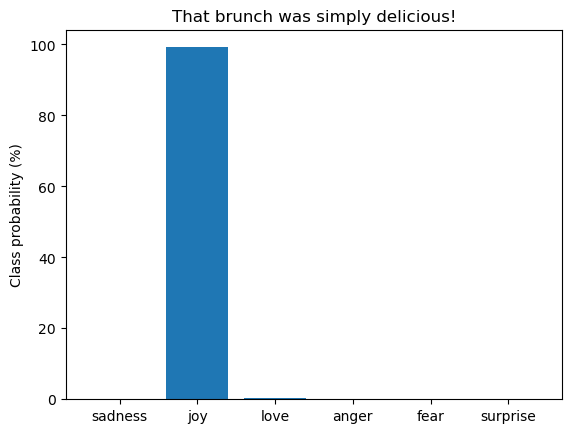

In [26]:
import pandas as pd

preds_df = pd.DataFrame(preds)

plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f"{test_tweet}")
plt.ylabel("Class probability (%)")

plt.show()